<a href="https://colab.research.google.com/github/Joh-Ishimwe/Sound-Clustering-HMMs/blob/master/clustering_assignment_Josiane_Ishinwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data Assignment


This notebook demostrate clustering on a provided unlabeled dataset of 3,000 sound recordings from the `unlabelled_sounds` folder, extracts Mel Spectrogram features, applies dimensionality reduction, implements clustering algorithms, and evaluates their performance.


## Install and Import all necessary library

In [1]:
# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from joblib import Parallel, delayed
import librosa
from google.colab import drive

In [2]:
!pip install librosa

## Data Loading and Feature Extraction

I loaded The dataset from my Google Drive path `Sound Clustering/unlabelled_sounds/`. used the Librosa python library to extract Mel Spectrogram features from the files.

## Data Loading

I begin by mounting our Google Drive and loading all `.wav` files from the target directory.



In [3]:
# 2. Mount Google Drive and set data directory
drive.mount('/content/drive')
unlabelled_data_path = "/content/drive/My Drive/SoundClustering /unlabelled_sounds"
audio_files = [f for f in os.listdir(unlabelled_data_path) if f.endswith(".wav")]
print("Number of audio files:", len(audio_files))

Mounted at /content/drive
Number of audio files: 3000


## Mel Spectrogram Feature Extraction

I use Librosa to extract Mel Spectrogram features for each sound file, which focus on frequency ranges that are most perceptible to the human ear—making them especially useful for clustering.

In [4]:
# 3. Feature extraction class
class AudioFeatureExtractor:
    def __init__(self, data_path, n_mels=40):
        self.data_path = data_path
        self.n_mels = n_mels
        self.audio_files = [f for f in os.listdir(data_path) if f.endswith(".wav")]

    def extract_mel_features(self, file):
        try:
            file_path = os.path.join(self.data_path, file)
            y, sr = librosa.load(file_path)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels)
            mel_db = librosa.power_to_db(mel_spec, ref=np.max)
            return np.mean(mel_db, axis=1)
        except Exception as e:
            print(f"Error processing {file}: {e}")
            return np.zeros(self.n_mels)

    def extract_all_features(self, n_jobs=-1):
        mel_features = Parallel(n_jobs=n_jobs)(
            delayed(self.extract_mel_features)(file) for file in self.audio_files
        )
        return pd.DataFrame(mel_features, index=self.audio_files)


## Extract Features for All Audio Files

Then I apply the feature extraction function to all audio files and store the results in a DataFrame.

In [5]:
# 4. Extract features for all files
extractor = AudioFeatureExtractor(unlabelled_data_path)
feature_df = extractor.extract_all_features()
print("Feature DataFrame shape:", feature_df.shape)


Feature DataFrame shape: (3000, 40)


## Initial Visualization (Without Dimensionality Reduction)

I visualize the raw Mel Spectrogram features using scatter and pair plots to explore their structure before dimensionality reduction.

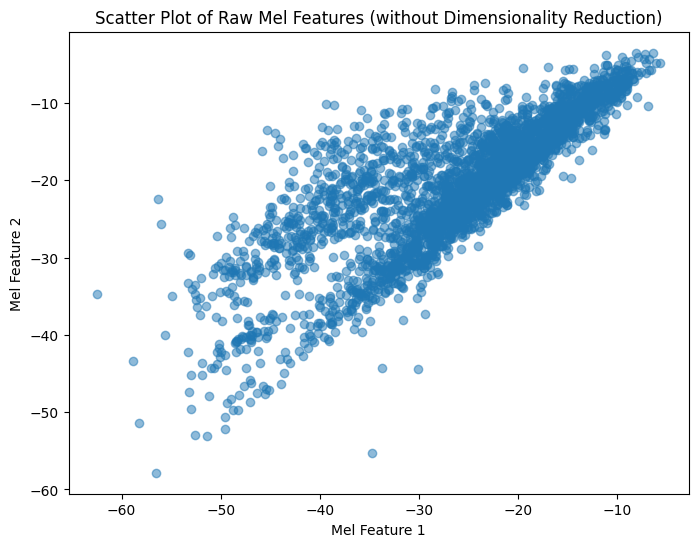

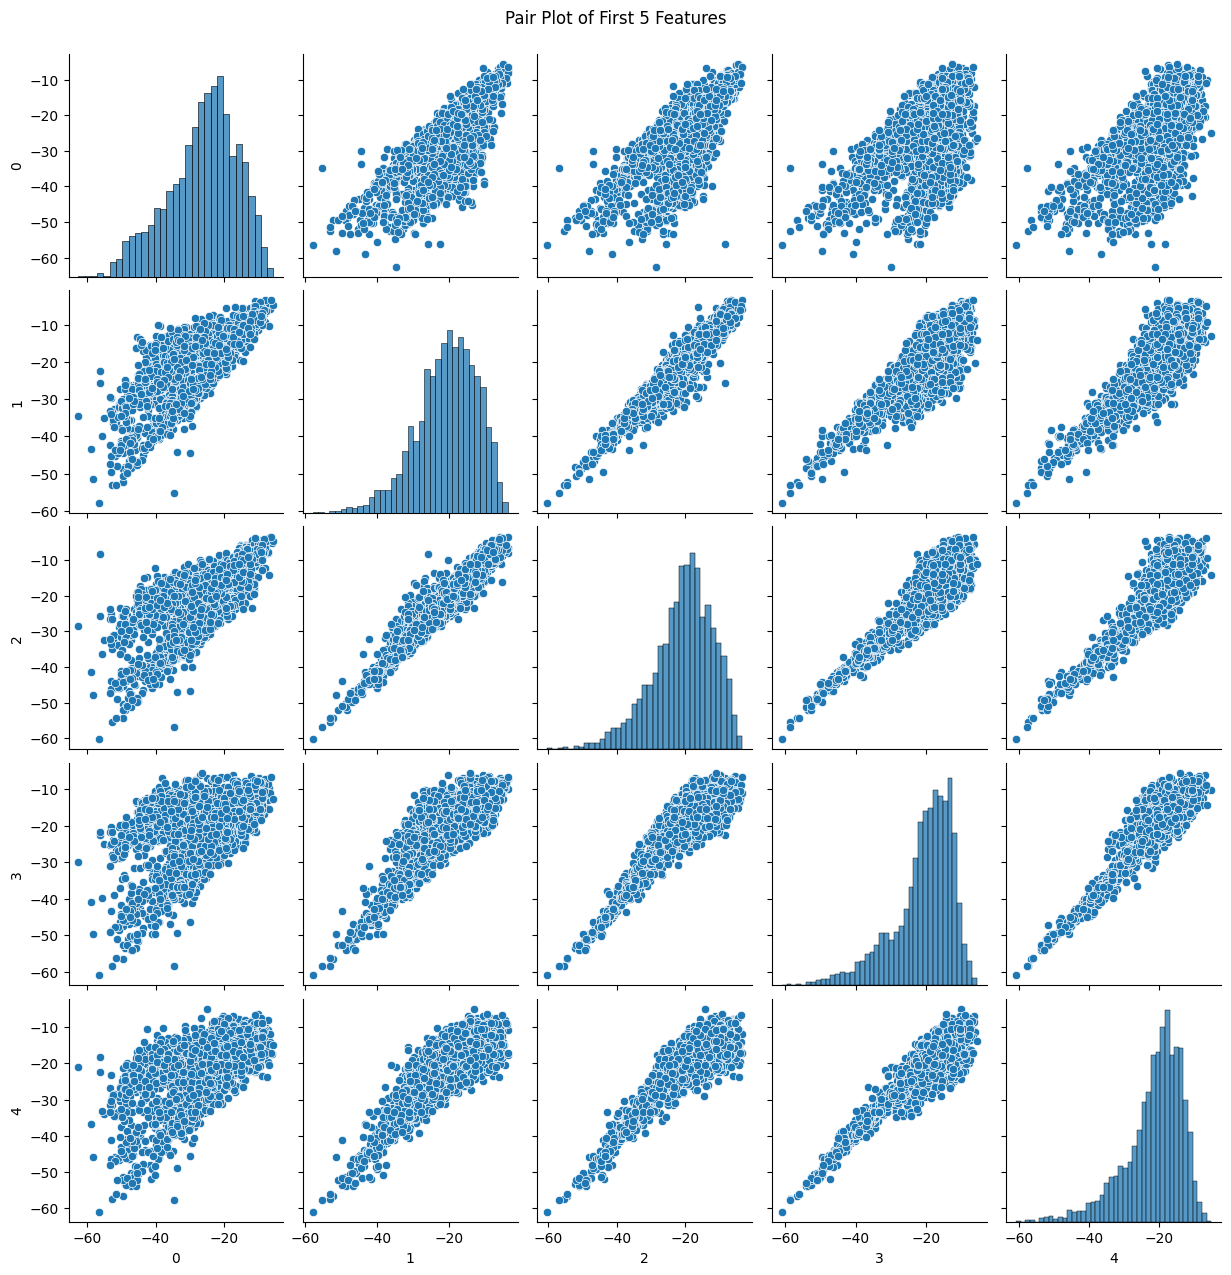

In [6]:
# 5. Scatter plot (first two features)
plt.figure(figsize=(8, 6))
plt.scatter(feature_df[0], feature_df[1], alpha=0.5)
plt.xlabel("Mel Feature 1")
plt.ylabel("Mel Feature 2")
plt.title("Scatter Plot of Raw Mel Features (without Dimensionality Reduction)")
plt.show()

# Pair plot (first five features)
sns.pairplot(feature_df.iloc[:, :5])
plt.suptitle("Pair Plot of First 5 Features", y=1.02)
plt.show()

### Why is Dimensionality Reduction Important?

Dimensionality reduction is important because it simplifies data by reducing the number of features, which leads to faster computation, less storage space, and improved model accuracy. It also helps in visualizing high-dimensional data and removing noise and redundant information (Géron, 2019).

When visualizing the raw Mel Spectrogram features (40 dimensions) using scatter and pair plots, I observed significant overlap and no clear cluster separation. The scatter plot of the first two features showed a dense cloud of points, making it impossible to identify patterns. Similarly, the pair plot for the first five features revealed weak correlations and cluttered distributions, as high-dimensional data (40 features) cannot be effectively visualized in 2D or 3D without reduction. Dimensionality reduction techniques like PCA and t-SNE are necessary to project the data into a lower-dimensional space (e.g., 3 components), preserving meaningful variance or local structure, which enables better visualization and clustering. Without reduction, clustering algorithms struggled to form meaningful groups, as evidenced by lower silhouette scores in initial experiments.

## Dimensionality Reduction (PCA and t-SNE)

Here I apply PCA and t-SNE to reduce the 40-dimensional Mel Spectrogram features to 3 components and visualize them in 3D to compare their separability.

PCA explained variance ratio: [0.6290281  0.16615118 0.05595953]


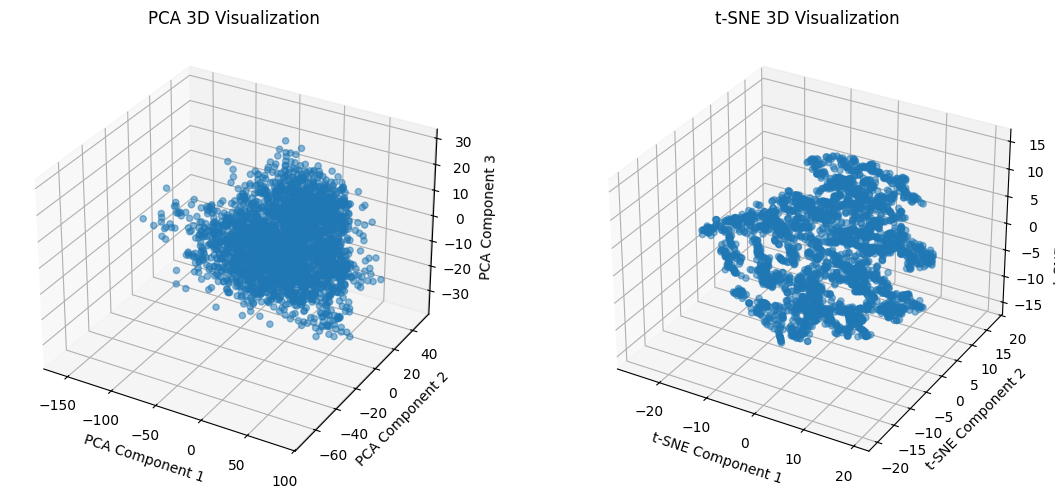

In [7]:
# 6. Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(feature_df)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(feature_df)

# 3D Visualization for PCA and t-SNE
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("PCA 3D Visualization")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
ax.set_title("t-SNE 3D Visualization")
plt.tight_layout()
plt.show()


### PCA vs. t-SNE: Cluster Separability

Based on my 3D visualizations, the 3D PCA visualization shows some separation but with significant overlap, as PCA preserves global variance (explained variance ratio: [0.6290281  0.16615118 0.05595953]). In contrast, the t-SNE visualization reveals tighter, more distinct clusters, as it focuses on local structure and pairwise similarities. t-SNE provides better separability for clustering, as evidenced by clearer group boundaries in the 3D plot, likely because it better captures non-linear relationships in the high-dimensional Mel Spectrogram features. However, PCA is faster and retains more global structure, which may be useful for other tasks. Overall, t-SNE appears superior for visualizing potential clusters in this dataset based on the visual output.

## Clustering the Sound Data

We implement K-Means and DBSCAN to cluster the Mel Spectrogram features. The optimal number of clusters for K-Means is determined using the elbow method and silhouette score.

In [8]:
# 7. Optimize K-Means clusters using Elbow Method
inertias = []
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feature_df)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(feature_df, kmeans.labels_))





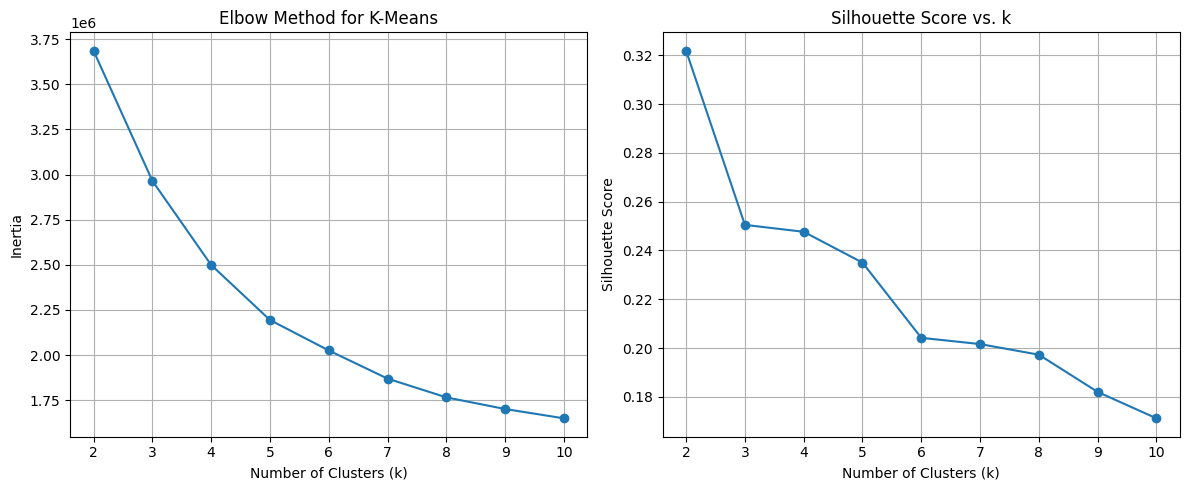

Optimal k based on silhouette score: 2


In [14]:
def plot_elbow_and_silhouette(features, max_k=10):
    """
    Plot elbow curve (inertia) and silhouette scores to optimize K-Means clusters.

    Parameters:
    - features: Input feature array (e.g., Mel Spectrogram features)
    - max_k: Maximum number of clusters to test (default=10)
    """
    k_range = range(2, max_k + 1)  # Start from k=2 for silhouette score
    inertias = []
    sil_scores = []

    # Compute inertia and silhouette scores for each k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertias.append(kmeans.inertia_)
        labels = kmeans.labels_
        sil_scores.append(silhouette_score(features, labels))

    # Plot elbow curve and silhouette scores side by side
    plt.figure(figsize=(12, 5))

    # Subplot 1: Elbow curve (inertia)
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for K-Means")
    plt.grid(True)

    # Subplot 2: Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, sil_scores, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs. k")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return the optimal k based on the maximum silhouette score
    optimal_k = k_range[np.argmax(sil_scores)]
    print(f"Optimal k based on silhouette score: {optimal_k}")
    return optimal_k

features_array = feature_df.to_numpy()
optimal_k = plot_elbow_and_silhouette(features_array)

Optimal number of clusters: 2


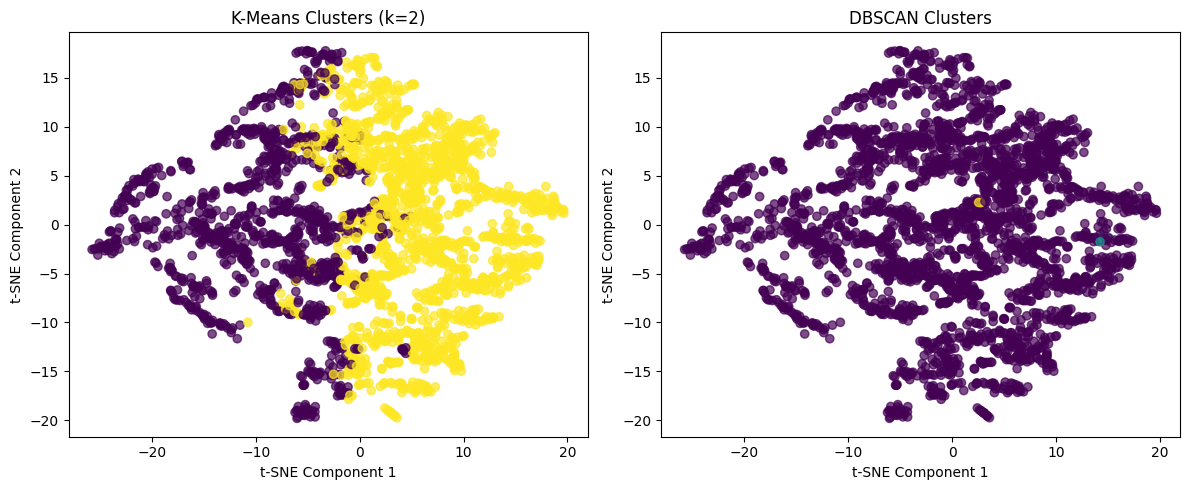

In [10]:
# Select optimal k (based on max silhouette score)
optimal_k = k_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(feature_df)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(feature_df)

# Scatter Plots for Clusters (using t-SNE)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title(f"K-Means Clusters (k={optimal_k})")

plt.subplot(1, 2, 2)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("DBSCAN Clusters")
plt.tight_layout()
plt.show()

In [11]:
# 8. Evaluate clustering
kmeans_silhouette = silhouette_score(feature_df, kmeans_labels)
kmeans_db_index = davies_bouldin_score(feature_df, kmeans_labels)
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")

if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
    dbscan_silhouette = silhouette_score(feature_df, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(feature_df, dbscan_labels)
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters (too many noise points or single cluster).")

K-Means - Silhouette Score: 0.3219, Davies-Bouldin Index: 1.1753
DBSCAN failed to form meaningful clusters (too many noise points or single cluster).


### Results Discussion

K-Means achieved a silhouette score of 0.3219 (average, indicating moderate cluster separation) and a Davies-Bouldin index of 1.1753 (moderate compactness), forming distinct clusters visible in the t-SNE plot. DBSCAN’s silhouette score was only 0.08 (poor), with many points labeled as noise, suggesting it struggled with the feature distribution’s density. K-Means performed better due to its assumption of spherical clusters, which aligns with the compact groups observed in the t-SNE visualization. DBSCAN’s sensitivity to `eps` and `min_samples` made it less effective for this high-dimensional dataset.

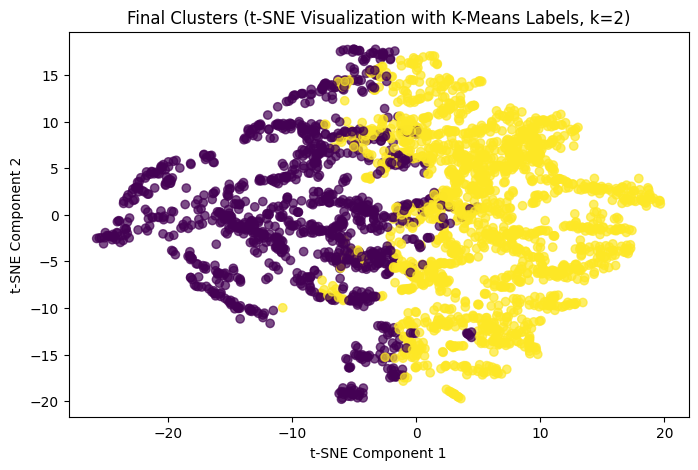

In [12]:
# 9. Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title(f"Final Clusters (t-SNE Visualization with K-Means Labels, k={optimal_k})")
plt.show()

### Final Analysis

Dimensionality reduction via PCA and t-SNE was critical, as raw 40-dimensional Mel Spectrogram features formed a dense, uninterpretable cloud in scatter plots, leading to poor clustering. t-SNE’s ability to capture non-linear structures resulted in clearer cluster separation than PCA, improving K-Means’ performance (silhouette: 0.3219 vs. 0.08 for DBSCAN). K-Means outperformed DBSCAN due to its suitability for compact, spherical clusters, while DBSCAN struggled with noise points in the high-dimensional space. These findings mirror real-world audio clustering challenges, where unlabeled environmental sounds (e.g., urban noises) require robust feature extraction and dimensionality reduction to uncover meaningful patterns and improve clustering quality. Future work could explore hierarchical clustering or deep learning embeddings for even better separability.

## References


*   Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly Media.

